In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

# constants
td = 1.0/25.0 # some videos are 1.0/30.0, but for the sake of simplicity all fps are assumed to be the same
minimum_frames = 75 # less than 3 seconds short bursts are filtered away
forecast_horizon = 10 # how many steps ahead we need to forecast

trace_files = ['ImageObjectKalmanFilteringTraceCar.txt','ImageObjectKalmanFilteringTraceCalf.txt',\
              'ImageObjectKalmanFilteringTraceBird.txt','ImageObjectKalmanFilteringTraceSailingBoat.txt',\
              'ImageObjectKalmanFilteringTraceSofa.txt']

# lets first print some statistics
approved_count_total = 0
approved_sum_total = 0
for trace_file in trace_files:
    print('File:',trace_file)
    data = pd.read_csv(trace_file)
    id_max = data['id'].max()
    print('   Image object count:', id_max)
    approved_count = 0
    approved_sum = 0
    for image_object_id in range(1, id_max+1):
        image_object_data = data.loc[data['id']==image_object_id]
        length,width = image_object_data.shape
        if length> minimum_frames:
            approved_count += 1
            approved_sum += length
            approved_count_total += 1
            approved_sum_total += length
    print('   Approved object count:', approved_count)
    print('   Average frames:', approved_sum/approved_count)
    print('   Average duration:', td*approved_sum/approved_count)
print('Total approved object count:', approved_count_total)
print('Total frames:', approved_sum_total)
print('Total duration:', td*approved_sum_total)
print('Total average frames:', approved_sum_total/approved_count_total)
print('Total average duration:', td*approved_sum_total/approved_count_total)
    

File: ImageObjectKalmanFilteringTraceCar.txt
   Image object count: 289
   Approved object count: 23
   Average frames: 128.91304347826087
   Average duration: 5.156521739130435
File: ImageObjectKalmanFilteringTraceCalf.txt
   Image object count: 17
   Approved object count: 3
   Average frames: 114.0
   Average duration: 4.56
File: ImageObjectKalmanFilteringTraceBird.txt
   Image object count: 5
   Approved object count: 1
   Average frames: 676.0
   Average duration: 27.04
File: ImageObjectKalmanFilteringTraceSailingBoat.txt
   Image object count: 1
   Approved object count: 1
   Average frames: 899.0
   Average duration: 35.96
File: ImageObjectKalmanFilteringTraceSofa.txt
   Image object count: 1
   Approved object count: 1
   Average frames: 139.0
   Average duration: 5.5600000000000005
Total approved object count: 29
Total frames: 5021
Total duration: 200.84
Total average frames: 173.13793103448276
Total average duration: 6.9255172413793105


In [2]:
# Demonstrate the optimization algorithm with one image object and one corner
data = pd.read_csv('ImageObjectKalmanFilteringTraceCar.txt')
example = data.loc[data['id']==32]
print(example.shape)

(150, 31)


In [3]:
# Take one corner and print size and few rows
x_min = pd.DataFrame({'time':example['time'], 'l' : example['x_min_m']})
x_min.index = x_min['time']
del x_min['time']
x_min.head()

,l
time,
2.32,310.0
2.36,304.0
2.40,300.0
2.44,304.0
2.48,296.0


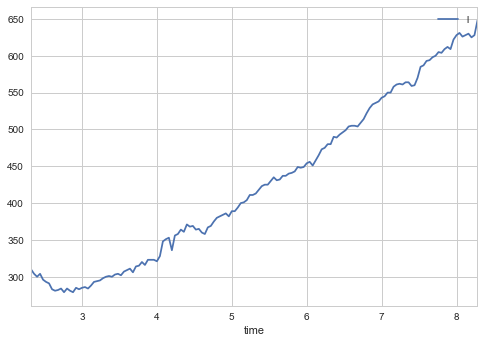

In [4]:
# Plot the measurement
x_min.plot()

In [5]:
# System matrices
A = np.array([[1.0, td],[0.0, 1.0]]) # state equation matrix
C = np.array([[1.0, 0.0]]) # measurement matrix
print(A)
print(C)

[[ 1.    0.04]
 [ 0.    1.  ]]
[[ 1.  0.]]


In [6]:
# Kalman filter parameters
r1 = 1.0 # location variance (state equation)
r2 = 1.0 # velocity variance (state equation)
q = 10.0 # measurement variance
# Kalman filter initial covariance
alfa = 10.0 # (location ininial variance)
beta = 10000.0 # (velocity initial variance)

In [7]:
# Kalman filter constant matrices
R = np.array([[r1, 0.0],[0.0, r2]]) # state equation variances
Q = np.array([q]) # measurent variance
print(R)
print(C)

[[ 1.  0.]
 [ 0.  1.]]
[[ 1.  0.]]


In [8]:
# Kalman filter initial values
mu = np.array([[x_min['l'].iloc[0]],[0.0]])
sigma = np.array([[alfa, 0],[0.0, beta]])
print(mu)
print(sigma)

[[ 310.]
 [   0.]]
[[    10.      0.]
 [     0.  10000.]]


In [9]:
# How many values in the mearurement?
length,width = x_min.shape
print(length)

150


In [10]:
# Storage area for measurements and filtered values
measurement = np.array([x_min['l'].iloc[0]])
filtered_location = np.array([x_min['l'].iloc[0]])
filtered_velocity = np.array([0.0])
variance_location = np.array([sigma[0,0]])
variance_velocity = np.array([sigma[1,1]])

In [11]:
# Let's filter through the signal
for i in range(1, length): # note '1': starting from the second value
    mu = A.dot(mu)
    sigma = A.dot(sigma).dot(A.T) + R
    K = sigma.dot(C.T).dot(np.linalg.inv(C.dot(sigma).dot(C.T) + Q))
    mu = mu + K.dot(x_min['l'].iloc[i]-C.dot(mu))
    sigma = (np.eye(2)-K.dot(C)).dot(sigma)
    # save the values:
    measurement = np.vstack((measurement, [x_min['l'].iloc[i]]))
    filtered_location = np.vstack((filtered_location, mu[0]))
    filtered_velocity = np.vstack((filtered_velocity, mu[1]))
    variance_location = np.vstack((variance_location, sigma[0,0]))
    variance_velocity = np.vstack((variance_velocity, sigma[1,1]))


In [12]:
print(measurement.shape)
print(filtered_location.shape)
print(filtered_velocity.shape)
print(variance_location.shape)
print(variance_velocity.shape)

(150, 1)
(150, 1)
(150, 1)
(150, 1)
(150, 1)


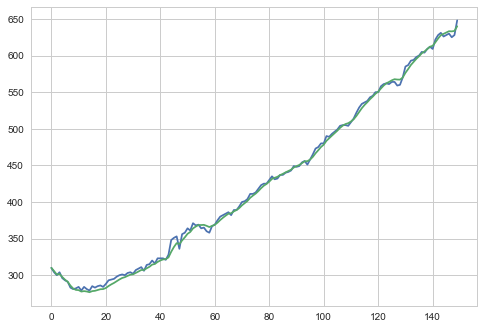

In [13]:
# Plot location
plt.plot(measurement)
plt.plot(filtered_location)

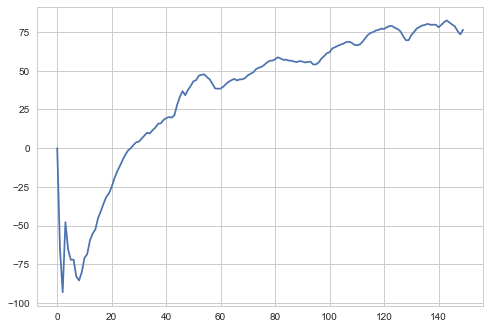

In [14]:
plt.plot(filtered_velocity)

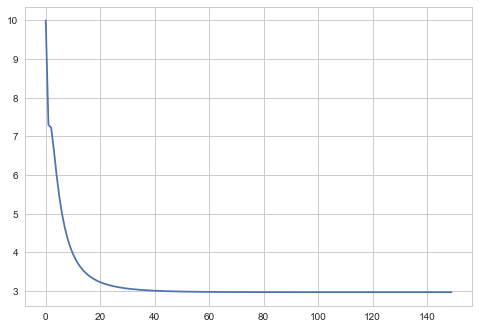

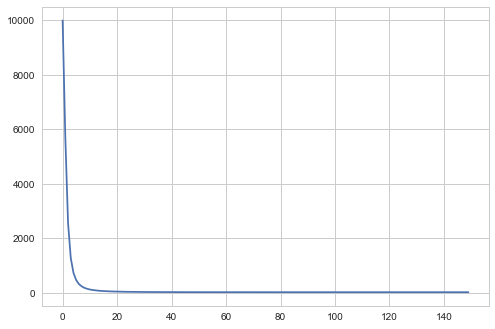

In [15]:
plt.figure()
plt.plot(variance_location)
plt.figure()
plt.plot(variance_velocity)

In [16]:
# Forecast error forecast_horizon steps ahead

In [17]:
forecast_error = np.array([0.0]) # first value with no forecast
for i in range(1, length-forecast_horizon): # note '1': starting from the second value
    current_error = 0.0
    mu = np.array([filtered_location[i],[filtered_velocity[i]]])
    for j in range(i, i+forecast_horizon):
        mu = A.dot(mu)
        current_error += np.abs((mu[0]-filtered_location[j]))
    forecast_error = np.vstack((forecast_error, current_error / forecast_horizon))

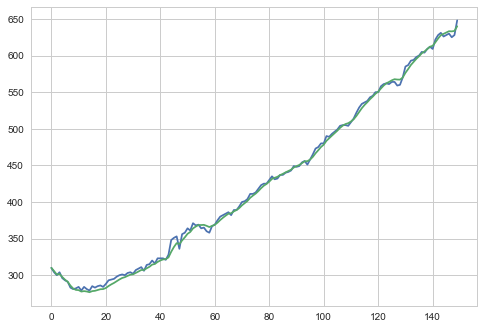

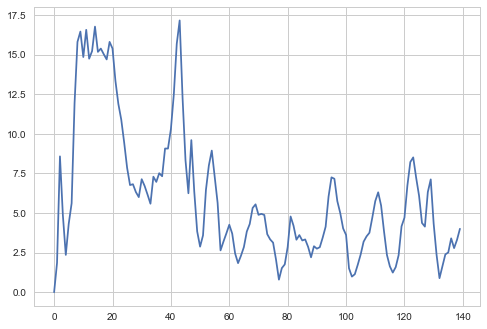

In [18]:
plt.figure()
plt.plot(measurement)
plt.plot(filtered_location)
plt.figure()
plt.plot(forecast_error)

In [19]:
# Mean prediction error forecast_horizon steps ahead:
mean_error = np.mean(forecast_error)
print(mean_error)

6.0674212899


In [20]:
# Let's do the same with a more static object
# Demonstrate the optimization algorithm with one image object and one corner
data = pd.read_csv('ImageObjectKalmanFilteringTraceCalf.txt')
example = data.loc[data['id']==1]
print(example.shape)

(161, 31)


In [21]:
# Take one corner and print size and few rows
y_max = pd.DataFrame({'time':example['time'], 'l' : example['y_max_m']})
y_max.index = y_max['time']
del y_max['time']
y_max.head()

,l
time,
0.033,650.0
0.067,654.0
0.100,654.0
0.133,654.0
0.167,655.0


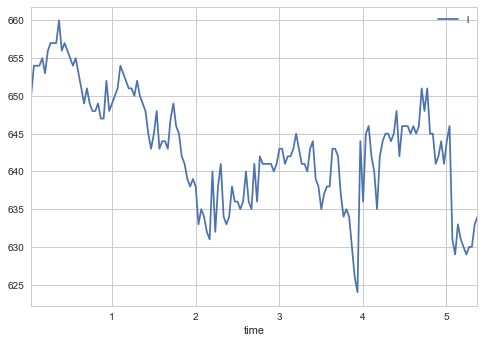

In [22]:
y_max.plot()

In [23]:
# Kalman filter initial values
mu = np.array([[y_max['l'].iloc[0]],[0.0]])
sigma = np.array([[alfa, 0],[0.0, beta]])
print(mu)
print(sigma)

[[ 650.]
 [   0.]]
[[    10.      0.]
 [     0.  10000.]]


In [24]:
# How many values in the mearurement?
length,width = y_max.shape
print(length)

161


In [25]:
# Storage area for measurements and filtered values
measurement = np.array([y_max['l'].iloc[0]])
filtered_location = np.array([y_max['l'].iloc[0]])
filtered_velocity = np.array([0.0])
variance_location = np.array([sigma[0,0]])
variance_velocity = np.array([sigma[1,1]])

In [26]:
# Let's filter through the signal
for i in range(1, length): # note '1': starting from the second value
    mu = A.dot(mu)
    sigma = A.dot(sigma).dot(A.T) + R
    K = sigma.dot(C.T).dot(np.linalg.inv(C.dot(sigma).dot(C.T) + Q))
    mu = mu + K.dot(y_max['l'].iloc[i]-C.dot(mu))
    sigma = (np.eye(2)-K.dot(C)).dot(sigma)
    # save the values:
    measurement = np.vstack((measurement, [y_max['l'].iloc[i]]))
    filtered_location = np.vstack((filtered_location, mu[0]))
    filtered_velocity = np.vstack((filtered_velocity, mu[1]))
    variance_location = np.vstack((variance_location, sigma[0,0]))
    variance_velocity = np.vstack((variance_velocity, sigma[1,1]))

In [27]:
print(measurement.shape)
print(filtered_location.shape)
print(filtered_velocity.shape)
print(variance_location.shape)
print(variance_velocity.shape)

(161, 1)
(161, 1)
(161, 1)
(161, 1)
(161, 1)


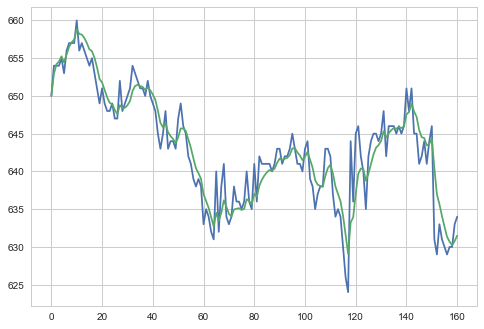

In [28]:
# Plot location
plt.plot(measurement)
plt.plot(filtered_location)

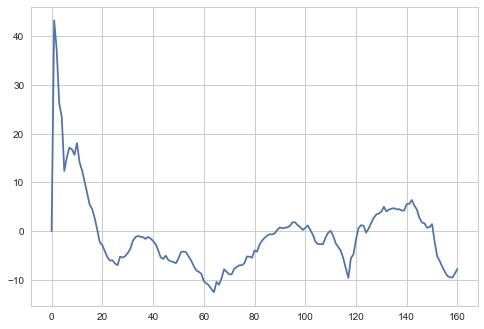

In [29]:
plt.plot(filtered_velocity)

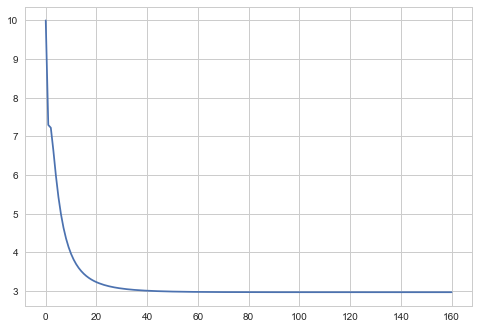

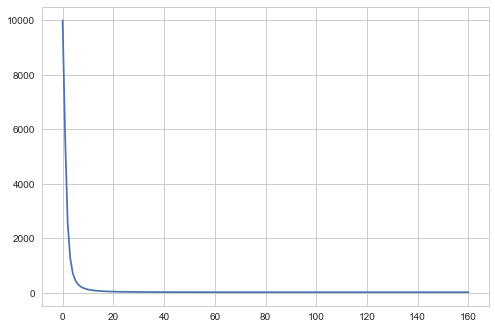

In [30]:
plt.figure()
plt.plot(variance_location)
plt.figure()
plt.plot(variance_velocity)

In [31]:
# Forecast error forecast_horizon steps ahead

In [32]:
forecast_error = np.array([0.0]) # first value with no forecast
for i in range(1, length-forecast_horizon): # note '1': starting from the second value
    current_error = 0.0
    mu = np.array([filtered_location[i],[filtered_velocity[i]]])
    for j in range(i, i+forecast_horizon):
        mu = A.dot(mu)
        current_error += np.abs((mu[0]-filtered_location[j]))
    forecast_error = np.vstack((forecast_error, current_error / forecast_horizon))

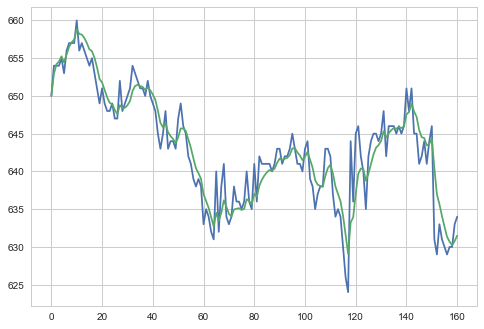

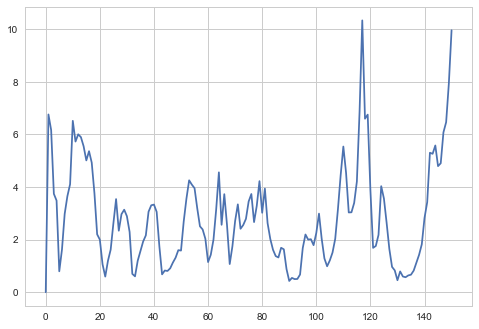

In [33]:
plt.figure()
plt.plot(measurement)
plt.plot(filtered_location)
plt.figure()
plt.plot(forecast_error)

In [34]:
# Mean prediction error forecast_horizon steps ahead:
mean_error = np.mean(forecast_error)
print(mean_error)

2.84065158476
